
# Polynomial Regression — From Theory to Practice


This notebook walks through **Polynomial Regression** end-to-end: the math foundations, practical implementation from scratch, scikit-learn usage, model evaluation, and clear visualizations.




## 1. What is Polynomial Regression?

Polynomial regression fits a **nonlinear** relationship between a scalar response $y$ and an input variable $x$ by modeling a **linear combination of polynomial basis functions**:

$$
\hat{y}(x) \;=\; \sum_{j=0}^{M} w_j \, x^{\,j}
\;=\;
\mathbf{w}^\top \boldsymbol{\phi}(x),
$$

where the **polynomial feature map** (basis) is
$$
\boldsymbol{\phi}(x) \;=\; \big[\,1,\; x,\; x^2,\;\ldots,\; x^M \,\big]^\top,
\qquad
\mathbf{w} = [w_0,\ldots,w_M]^\top.
$$

Despite the nonlinear curve in $x$, the model is **linear in parameters** $\mathbf{w}$, so we can use linear regression machinery.



## 2. Least Squares Objective

Given training pairs $\{(x_i,y_i)\}_{i=1}^n$, stack features into the **design matrix** $ \mathbf{X}\in\mathbb{R}^{n\times (M+1)}$ with rows
$
\boldsymbol{\phi}(x_i)^\top
$.
The **mean squared error (MSE)** objective is

$$
\mathcal{L}(\mathbf{w}) \;=\; \frac{1}{n}\sum_{i=1}^{n}\big(y_i - \mathbf{w}^\top \boldsymbol{\phi}(x_i)\big)^2
\;=\;
\frac{1}{n}\,\|\mathbf{y}-\mathbf{X}\mathbf{w}\|_2^2.
$$

The (unregularized) **normal equations** give the solution (assuming invertibility):

$$
\mathbf{w}^\star \;=\; \big(\mathbf{X}^\top \mathbf{X}\big)^{-1}\mathbf{X}^\top \mathbf{y}.
$$



## 3. Regularization (Ridge)

High-degree polynomials can severely **overfit**. **Ridge** regression adds an $\ell_2$ penalty:

$$
\mathcal{L}_\lambda(\mathbf{w}) \;=\; \frac{1}{n}\,\|\mathbf{y}-\mathbf{X}\mathbf{w}\|_2^2 \;+\; \lambda \|\mathbf{w}\|_2^2,
$$

leading to the **closed form**

$$
\mathbf{w}_\lambda^\star \;=\; \big(\mathbf{X}^\top \mathbf{X} + n\lambda\,\mathbf{I}\big)^{-1}\mathbf{X}^\top \mathbf{y}.
$$

Here $\lambda \ge 0$ controls the strength of regularization.



## 4. Model Complexity and Bias–Variance

- **Low degree $M$**: High bias, underfitting.
- **High degree $M$**: Low bias but high variance, overfitting.
- Use a **validation set** or **cross-validation** to pick $M$ and (optionally) $\lambda$.


In [1]:

# 5. Imports and Helper Functions
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, KFold

np.random.seed(42)

def make_synthetic_data(n=100, noise_std=0.2):
    """Create 1D data from a smooth nonlinear function with Gaussian noise."""
    X = np.sort(np.random.uniform(-3, 3, size=n))
    y_true = np.sin(X) + 0.5 * np.cos(2*X)
    y = y_true + np.random.normal(scale=noise_std, size=n)
    return X.reshape(-1, 1), y, y_true

def polynomial_design_matrix(x, degree):
    """Generate a polynomial design matrix [1, x, x^2, ..., x^degree]."""
    X = np.hstack([x**j for j in range(degree + 1)])
    return X

def fit_closed_form(X, y, lam=0.0):
    """Closed-form solution for (ridge) linear regression on polynomial features."""
    n, d = X.shape
    A = X.T @ X + n * lam * np.eye(d)
    b = X.T @ y
    w = np.linalg.solve(A, b)
    return w

def predict_with_weights(X, w):
    return X @ w


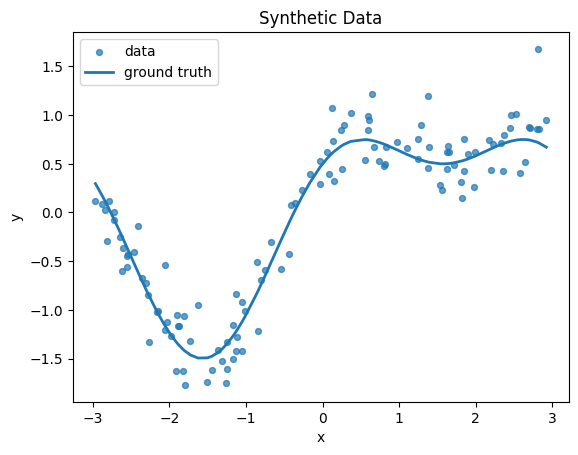

In [2]:

# 6. Generate Data and Visualize
X, y, y_true = make_synthetic_data(n=120, noise_std=0.25)

plt.figure()
plt.scatter(X, y, s=18, alpha=0.7, label="data")
plt.plot(X, y_true, linewidth=2, label="ground truth")
plt.title("Synthetic Data")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.show()


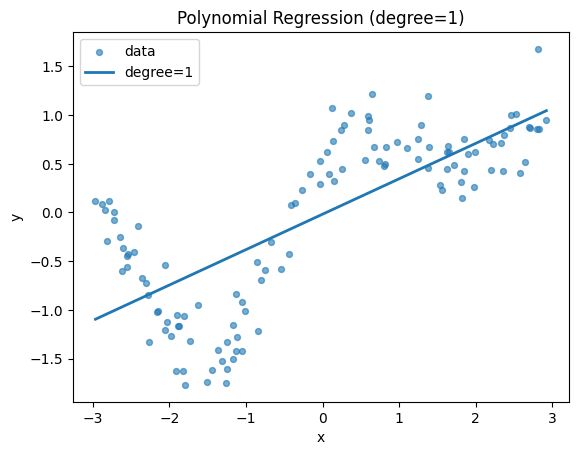

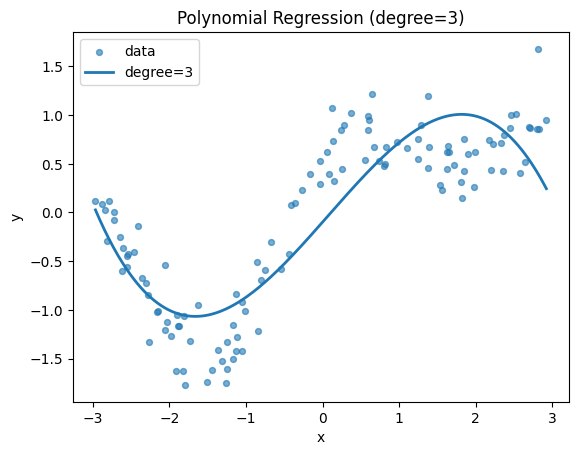

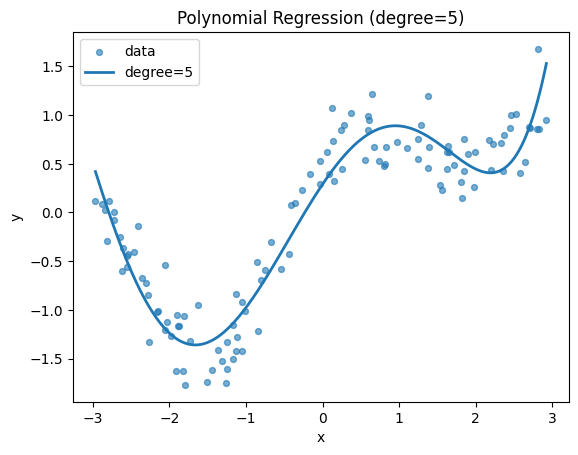

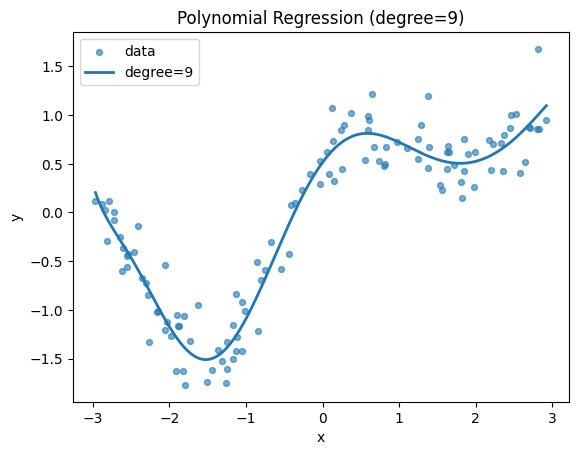

In [3]:

# 7. Fit Different Degrees (Closed-Form) and Visualize Fits

degrees = [1, 3, 5, 9]
x_plot = np.linspace(X.min(), X.max(), 400).reshape(-1, 1)

for deg in degrees:
    # Build design matrices
    Phi = polynomial_design_matrix(X, deg)
    Phi_plot = polynomial_design_matrix(x_plot, deg)

    # Fit closed-form without regularization
    w = fit_closed_form(Phi, y, lam=0.0)

    # Predict on dense grid
    y_hat_plot = predict_with_weights(Phi_plot, w)

    plt.figure()
    plt.scatter(X, y, s=18, alpha=0.6, label="data")
    plt.plot(x_plot, y_hat_plot, linewidth=2, label=f"degree={deg}")
    plt.title(f"Polynomial Regression (degree={deg})")
    plt.xlabel("x")
    plt.ylabel("y")
    plt.legend()
    plt.show()


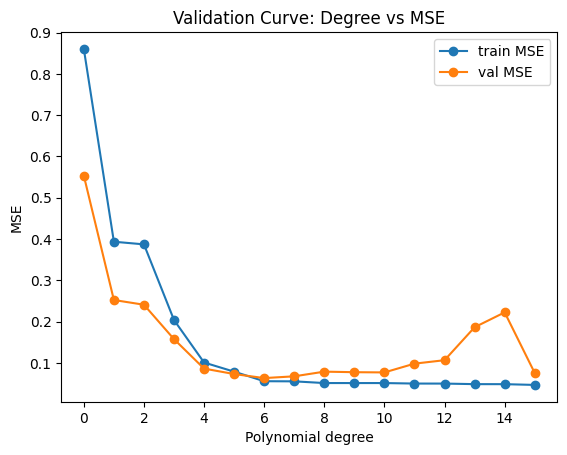

6

In [4]:

# 8. Degree Selection via Validation Curve

Xtr, Xval, ytr, yval = train_test_split(X, y, test_size=0.3, random_state=0)
degrees_range = list(range(0, 16))
mse_tr, mse_val = [], []

for deg in degrees_range:
    Phi_tr = polynomial_design_matrix(Xtr, deg)
    Phi_val = polynomial_design_matrix(Xval, deg)
    w = fit_closed_form(Phi_tr, ytr, lam=0.0)
    mse_tr.append(mean_squared_error(ytr, predict_with_weights(Phi_tr, w)))
    mse_val.append(mean_squared_error(yval, predict_with_weights(Phi_val, w)))

plt.figure()
plt.plot(degrees_range, mse_tr, marker="o", label="train MSE")
plt.plot(degrees_range, mse_val, marker="o", label="val MSE")
plt.title("Validation Curve: Degree vs MSE")
plt.xlabel("Polynomial degree")
plt.ylabel("MSE")
plt.legend()
plt.show()

best_deg = degrees_range[int(np.argmin(mse_val))]
best_deg


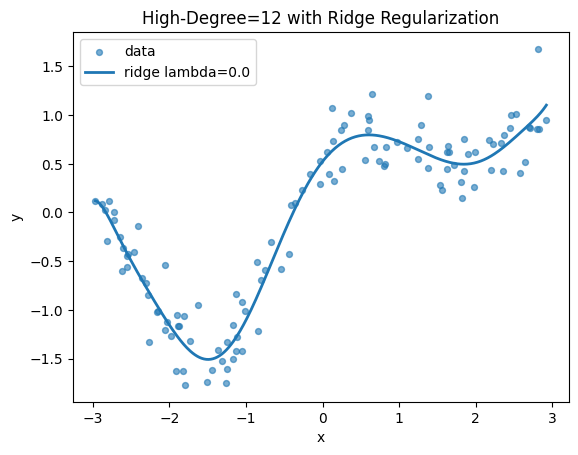

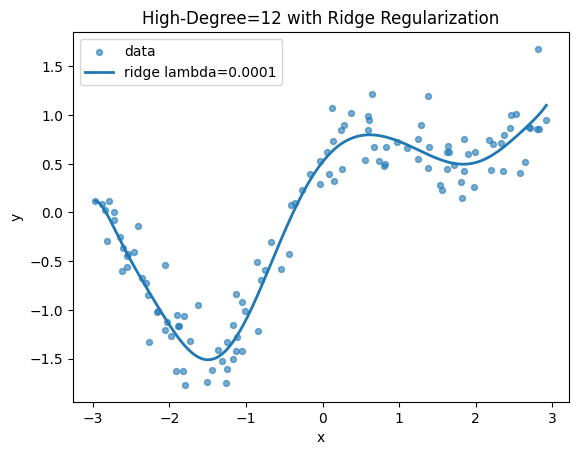

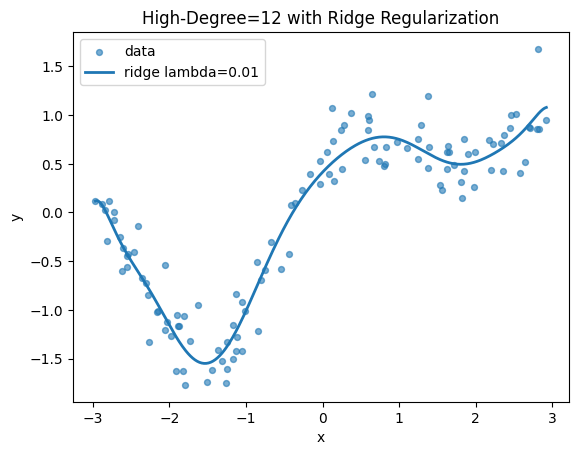

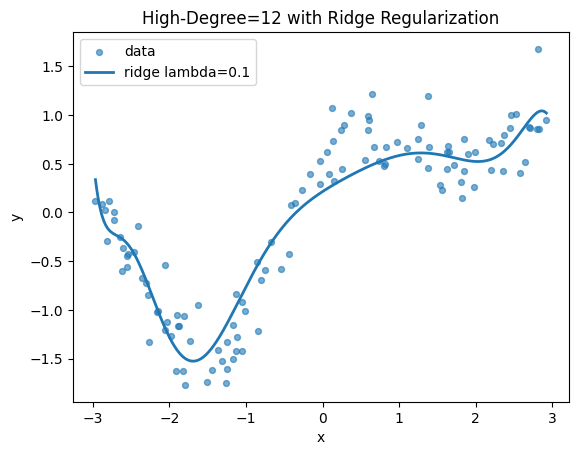

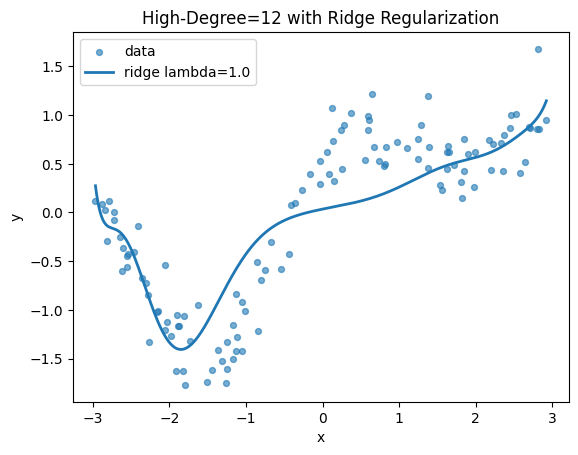

In [5]:

# 9. Effect of Ridge Regularization for a High Degree

deg = max(12, int(best_deg) + 3)
Phi = polynomial_design_matrix(X, deg)
x_plot = np.linspace(X.min(), X.max(), 400).reshape(-1, 1)
Phi_plot = polynomial_design_matrix(x_plot, deg)

lambdas = [0.0, 1e-4, 1e-2, 1e-1, 1.0]

for lam in lambdas:
    w_ridge = fit_closed_form(Phi, y, lam=lam)
    y_plot = predict_with_weights(Phi_plot, w_ridge)

    plt.figure()
    plt.scatter(X, y, s=18, alpha=0.6, label="data")
    plt.plot(x_plot, y_plot, linewidth=2, label=f"ridge lambda={lam}")
    plt.title(f"High-Degree={deg} with Ridge Regularization")
    plt.xlabel("x")
    plt.ylabel("y")
    plt.legend()
    plt.show()


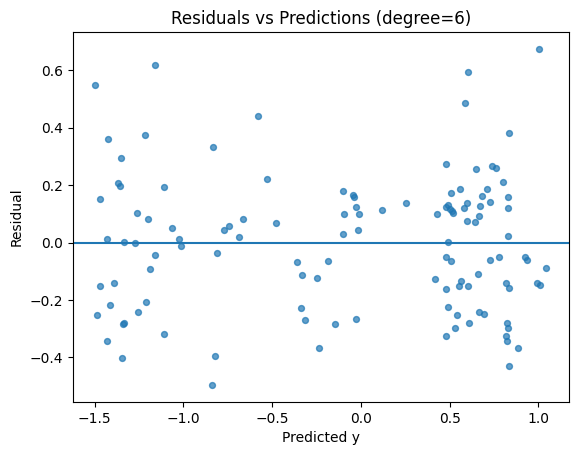

In [6]:

# 10. Residual Plot for the Selected Degree

deg = int(best_deg)
Phi = polynomial_design_matrix(X, deg)
w = fit_closed_form(Phi, y, lam=0.0)
y_pred = predict_with_weights(Phi, w)
residuals = y - y_pred

plt.figure()
plt.scatter(y_pred, residuals, s=18, alpha=0.7)
plt.axhline(0.0)
plt.title(f"Residuals vs Predictions (degree={deg})")
plt.xlabel("Predicted y")
plt.ylabel("Residual")
plt.show()



## 11. Using scikit-learn (Pipeline)

We can replicate the same workflow with scikit-learn using `PolynomialFeatures` and `LinearRegression` (or `Ridge`). Let $d$ denote the chosen degree.


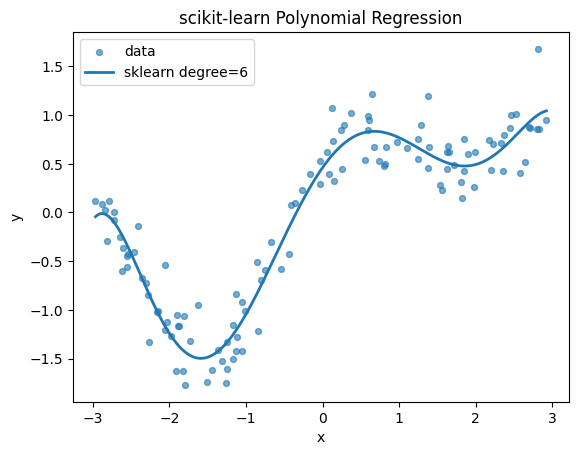

In [7]:

from sklearn.pipeline import make_pipeline

deg = int(best_deg)

lin_model = make_pipeline(PolynomialFeatures(degree=deg, include_bias=True),
                          LinearRegression())
lin_model.fit(X, y)

x_plot = np.linspace(X.min(), X.max(), 400).reshape(-1, 1)
y_lin = lin_model.predict(x_plot)

plt.figure()
plt.scatter(X, y, s=18, alpha=0.6, label="data")
plt.plot(x_plot, y_lin, linewidth=2, label=f"sklearn degree={deg}")
plt.title("scikit-learn Polynomial Regression")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.show()


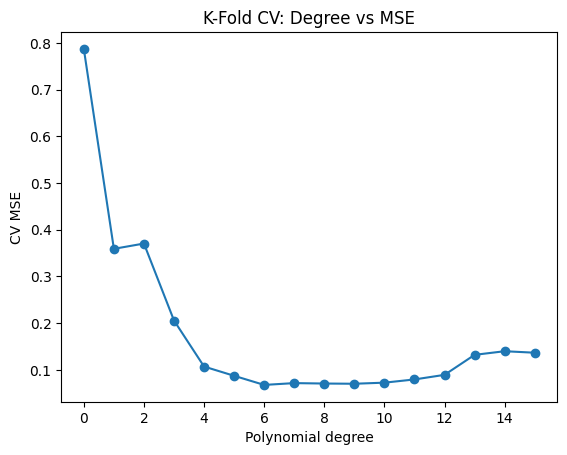

6

In [8]:

# 12. K-Fold Cross-Validation to Choose the Degree

def cv_score_for_degree(degree, X, y, K=5):
    kf = KFold(n_splits=K, shuffle=True, random_state=0)
    scores = []
    for tr_idx, va_idx in kf.split(X):
        Xtr, Xva = X[tr_idx], X[va_idx]
        ytr, yva = y[tr_idx], y[va_idx]
        model = make_pipeline(PolynomialFeatures(degree=degree, include_bias=True),
                              LinearRegression())
        model.fit(Xtr, ytr)
        pred = model.predict(Xva)
        scores.append(mean_squared_error(yva, pred))
    return np.mean(scores)

degrees_range = list(range(0, 16))
cv_mse = [cv_score_for_degree(d, X, y, K=5) for d in degrees_range]

plt.figure()
plt.plot(degrees_range, cv_mse, marker="o")
plt.title("K-Fold CV: Degree vs MSE")
plt.xlabel("Polynomial degree")
plt.ylabel("CV MSE")
plt.show()

cv_best_deg = degrees_range[int(np.argmin(cv_mse))]
cv_best_deg



## 13. Notes on Notation and Math in Jupyter

This notebook uses math blocks like in the example you provided. For instance, Bayes' theorem (not directly needed here, but shown for formatting) can be typeset as:

$$
P(y \mid \mathbf{x}) = \frac{P(\mathbf{x}\mid y)\,P(y)}{P(\mathbf{x})}
\;\propto\;
P(\mathbf{x}\mid y)\,P(y).
$$

And when referring to variables inline, we write things like: $x \in \mathbb{R}$, feature vector $\mathbf{x}=(x_1,\ldots,x_d)$, or degree $M$.



## 14. Practical Tips

- **Scale inputs** when $|x|$ is large or when using high degrees to improve numerical stability (e.g., standardize $x$ to zero mean, unit variance).
- Prefer **cross-validation** for selecting degree and regularization.
- Inspect **residual plots** and **validation curves** to diagnose under/overfitting.
- For multivariate inputs $\mathbf{x}\in\mathbb{R}^d$, `PolynomialFeatures` can generate interaction terms.
